In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

In [2]:
NUM_SAMPLES: int = 1000
STATE: int = 2023
IN_FEATURES: int = 2
OUT_FEATURES: int = 1
CLASS_SEP = 1
TEMPLATE = "ggplot2"

In [3]:
import torch
from sklearn.datasets import make_moons, make_circles
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


PALETTE = px.colors.qualitative.Plotly
figKwargs = dict(
    width=500,
    height=400,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots

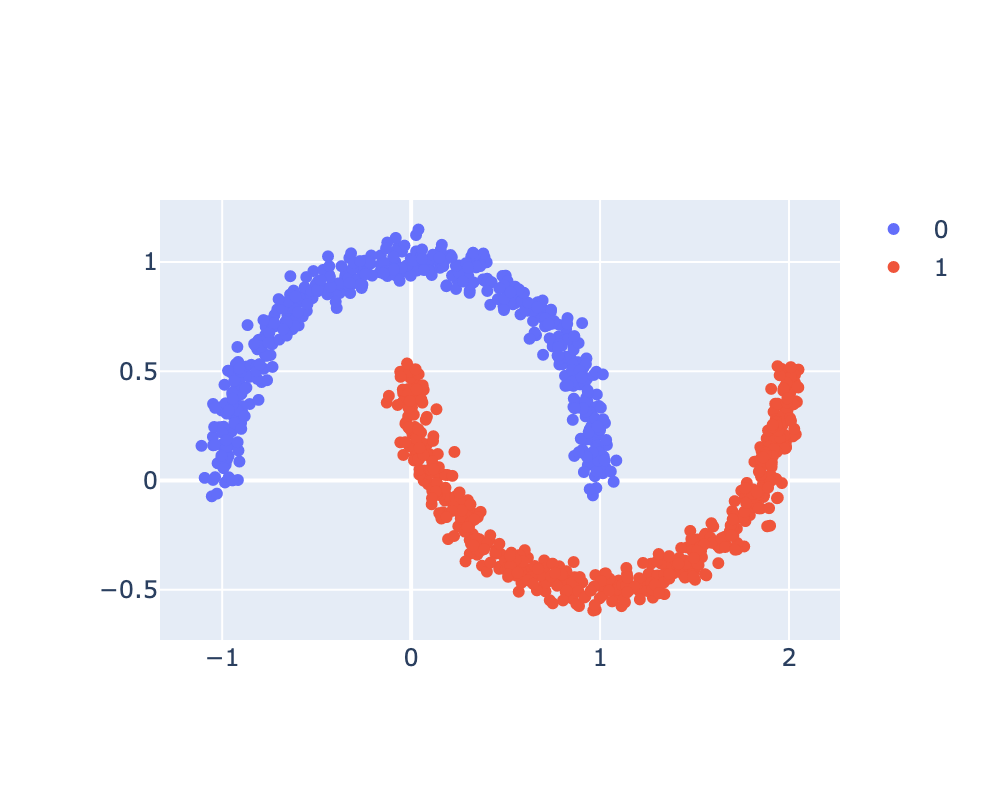

In [4]:
X, y = make_moons(n_samples=NUM_SAMPLES, noise=0.05)
color = ["Positive" if i else "Negative" for i in y]
color = y.astype(str)
labels = {"color": "label"}
# X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)
if y.ndim == 1:
    y = y[..., None]

fig = go.Figure(layout=figKwargs)
for cls in torch.unique(y):
    x = X[y.squeeze() == cls]
    y_ = int(cls.item())
    fig.add_trace(
        go.Scatter(
            x=x[:, 0], y=x[:, 1], mode="markers", name=f"{y_}", line_color=PALETTE[y_]
        )
    )
fig.show(**showKwargs)

In [16]:
from ml.losses.classification import BCELoss
from ml.activations.functional import sigmoid
from ml.activations import ReLU, Sigmoid
from ml.models.linear import Linear
from ml.models.nn import Sequential
from ml.optim import SGD

LR = 0.1
REG = 0.1
N = 5000

In [17]:
model = Sequential(
    [Linear(IN_FEATURES, 16), ReLU(), Linear(16, OUT_FEATURES)], activation=sigmoid
)
optim = SGD(model.parameters(), model.grad(), LR, REG)
criterion = BCELoss()

In [18]:
out = model(X)
loss, _ = criterion(out, y)
loss

tensor(0.6876)

In [19]:
model.fit(X, y, criterion, optim, N)

100%|██████████| 5000/5000 [00:01<00:00, 3183.91it/s]


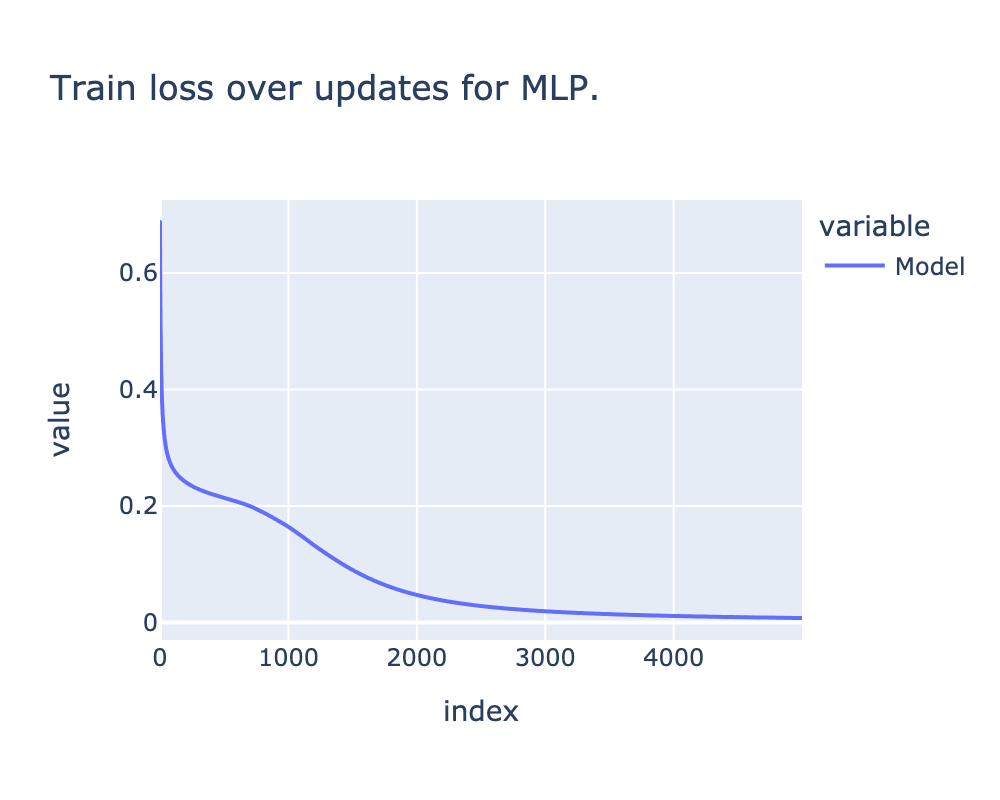

In [20]:
data = pd.DataFrame(dict(Model=model.history))
fig = px.line(
    data,
    title="Train loss over updates for MLP.",
    **figKwargs,
)
fig.show(**showKwargs)

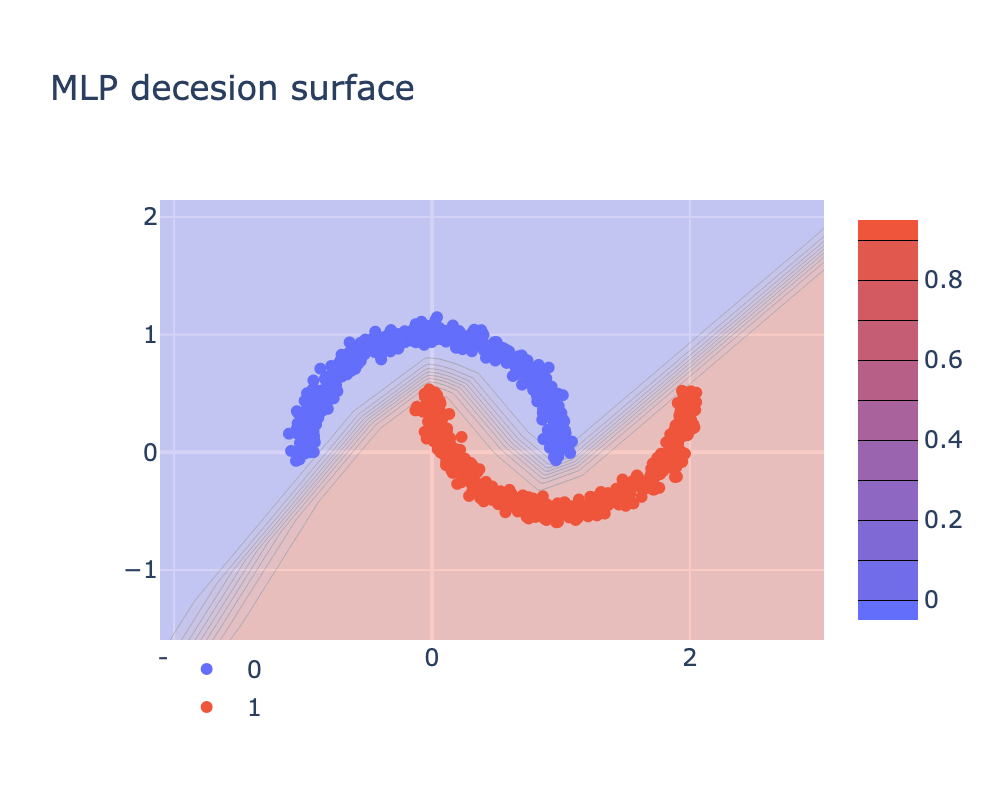

In [21]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = torch.meshgrid(
    torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing="ij"
)
levels = torch.linspace(0, 1, 1000)
grid = torch.dstack([xx.ravel(), yy.ravel()])[0]
gridOut = model.predict(grid)

fig = go.Figure(
    data=go.Contour(
        x=xx[:, 0],
        y=yy[0],
        z=gridOut.reshape(xx.shape).T,
        opacity=0.3,
        line_smoothing=1.0,
        colorscale=PALETTE[: int(y.max().item() + 1)],
    )
)
for cls in torch.unique(y):
    x = X[y.squeeze() == cls]
    y_ = int(cls.item())
    fig.add_trace(
        go.Scatter(
            x=x[:, 0], y=x[:, 1], mode="markers", name=f"{y_}", line_color=PALETTE[y_]
        )
    )
fig.update_layout(
    title="MLP decesion surface",
    legend=dict(yanchor="top", y=0.00, xanchor="left", x=0.01),
    **figKwargs,
)
fig.show(**showKwargs)

In [22]:
from ml.metrics.functional import get_stats, accuracy

thr = 0.5
b_output = (model.predict(X) > thr).to(torch.long)
b_target = y.to(torch.long)
stats = get_stats(b_output, b_target)
accuracy(*stats, average="micro")

tensor(1.)